In [10]:
# 03_train_fault_classifier.ipynb

import os
import joblib
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    PrecisionRecallDisplay,
)
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")

PROCESSED_PATH = os.path.join("..", "data", "processed", "ai4i2020_prepared.csv")
MODEL_PATH = os.path.join("..", "models", "fault", "failure_classifier.pkl")
os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)


In [11]:
df = pd.read_csv(PROCESSED_PATH)

target = "Machine failure"

# Columns we DON'T want as features (all failure labels)
failure_cols = ["Machine failure", "TWF", "HDF", "PWF", "OSF", "RNF"]

X = df.drop(columns=failure_cols)
y = df[target].astype(int)

cat_cols = ["Type"]
num_cols = [c for c in X.columns if c not in cat_cols]

print("Class distribution:")
print(y.value_counts())
print("Class distribution (ratio):")
print(y.value_counts(normalize=True))


Class distribution:
Machine failure
0    9661
1     339
Name: count, dtype: int64
Class distribution (ratio):
Machine failure
0    0.9661
1    0.0339
Name: proportion, dtype: float64


In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [13]:
# Preprocessing (no leakage: fit on train only inside pipeline)
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(drop="first"), cat_cols),
    ]
)

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    n_jobs=-1,
    random_state=42,
    # we can leave class_weight=None because SMOTE balances the classes
    class_weight=None,
)

pipe = ImbPipeline(steps=[
    ("preprocess", preprocess),
    ("smote", SMOTE(random_state=42)),
    ("model", rf),
])

pipe.fit(X_train, y_train)


,steps,"[('preprocess', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [14]:
# check SMOTE effect
from collections import Counter

# Access the resampled data by calling fit_resample manually on a copy
X_res, y_res = pipe.named_steps["smote"].fit_resample(
    pipe.named_steps["preprocess"].fit_transform(X_train),
    y_train
)
print("After SMOTE:", Counter(y_res))


After SMOTE: Counter({0: 7729, 1: 7729})


              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1932
           1       0.62      0.82      0.71        68

    accuracy                           0.98      2000
   macro avg       0.81      0.90      0.85      2000
weighted avg       0.98      0.98      0.98      2000

ROC-AUC: 0.9689402935087079


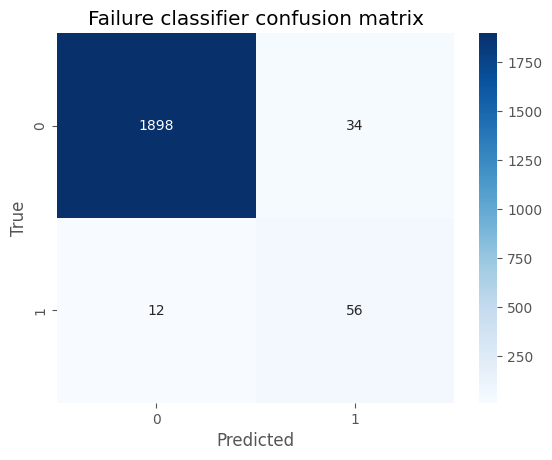

In [15]:
y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Failure classifier confusion matrix")
plt.show()


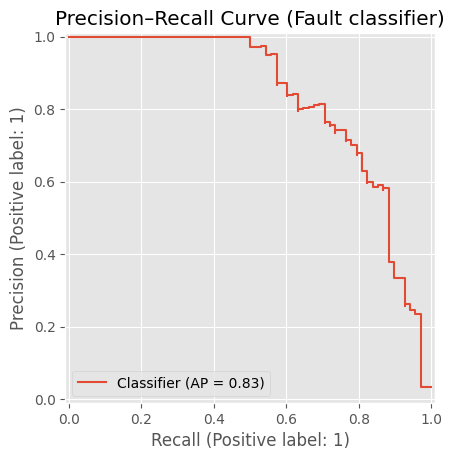

In [16]:
PrecisionRecallDisplay.from_predictions(y_test, y_proba)
plt.title("Precision–Recall Curve (Fault classifier)")
plt.show()


In [17]:
joblib.dump(pipe, MODEL_PATH)
MODEL_PATH


'../models/fault/failure_classifier.pkl'